In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, cross_validate

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data = pd.read_csv('model_data.csv', index_col='PID')
data.shape

(2579, 20)

#### Independent Variable (y)

In [3]:
y = data.SalePrice.copy()
data.drop('SalePrice', axis=1, inplace=True)

## 📉 Multiple Regression 1

#### Choose Dependent Vars

In [4]:
data.Neighborhood.unique()

array(['NAmes', 'Gilbert', 'StoneBr', 'NWAmes', 'Somerst', 'BrDale',
       'NPkVill', 'NridgHt', 'Blmngtn', 'NoRidge', 'SawyerW', 'Sawyer',
       'Veenker', 'Greens', 'BrkSide', 'OldTown', 'IDOTRR', 'ClearCr',
       'Edwards', 'SWISU', 'CollgCr', 'Landmrk', 'Crawfor', 'Blueste',
       'Mitchel', 'Timber', 'GrnHill', 'MeadowV'], dtype=object)

In [5]:
#ss = StandardScaler()
#X = ss.fit_transform(data_1)

lasso = Lasso(max_iter=10000)

data_dum = pd.get_dummies(data, drop_first=True)
scores = cross_validate(lasso, data_dum, np.log10(y), cv=4)
scores['test_score']

array([0.63512532, 0.62695495, 0.56951125, 0.68394824])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data_dum, y, test_size=0.2)

In [7]:
lasso.fit(X_train,np.log10(y_train))
lasso.score(X_test,np.log10(y_test))

0.7359091615074259

In [8]:
lasso.set_params(normalize=True, max_iter=10000, random_state=44)
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': 44,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [9]:
#try different alphas
alphas = np.linspace(0,0.002,100)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, np.log10(y_train)))
    R2_test.append(lasso.score(X_test, np.log10(y_test)))

<ipython-input-9-02d8d1909f26>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, np.log10(y_train))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2422817377216893, tolerance: 0.005724231863499106
  model = cd_fast.enet_coordinate_descent(


In [10]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,BsmtUnfSF,AllBathBsmt,AllBathAbv,YearBuilt,GarageCars,PorchArea,GoodLivArea,HasPool,MSSubClass_1FlPUD,MSSubClass_2Fl,...,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0.00000,0.000064,0.009527,0.008714,0.000332,0.020024,0.000043,0.000102,-0.022144,-0.032219,0.019316,...,-0.013534,0.000598,-0.020962,0.001209,-0.00588,-0.12373,-0.091746,-0.10295,-0.181014,-0.100744
0.00002,0.000062,0.004272,0.006727,0.000537,0.023128,0.000044,0.000107,-0.000364,-0.019477,0.017099,...,-0.004231,0.005026,-0.017356,0.000000,0.00000,-0.01869,0.004737,-0.00000,-0.047781,0.000000


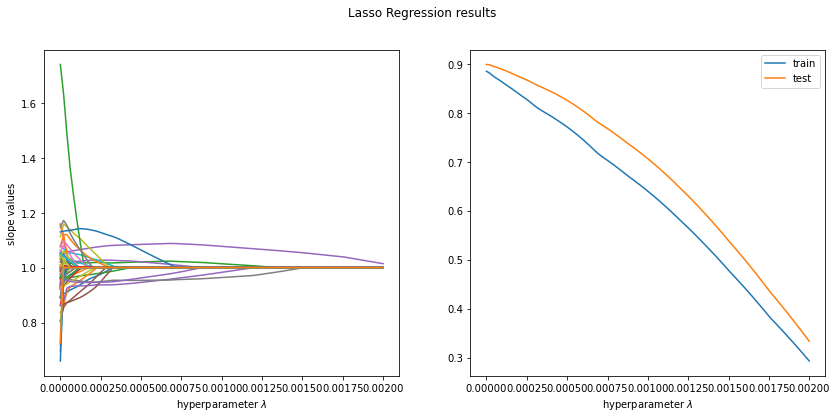

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

## DUmp into PICKLE 🥒

In [85]:
print(R2_lasso.loc[R2_lasso['test']==max(R2_lasso['test'])])
lasso.set_params(alpha=0.00001)
lasso.fit(X_train, np.log10(y_train))

        train      test
0.0  0.884771  0.898729


Lasso(alpha=1e-05, max_iter=10000, normalize=True, random_state=44)

In [86]:
import pickle
pickle.dump(lasso, open('APP_model.pkl', 'wb'))

In [77]:
len(X_train.columns)

72

# Check VIFS

In [11]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# VIFs over 10
vif[vif.VIF>10]

#### Check Corr Heatmap for Continuous Variables

<AxesSubplot:>

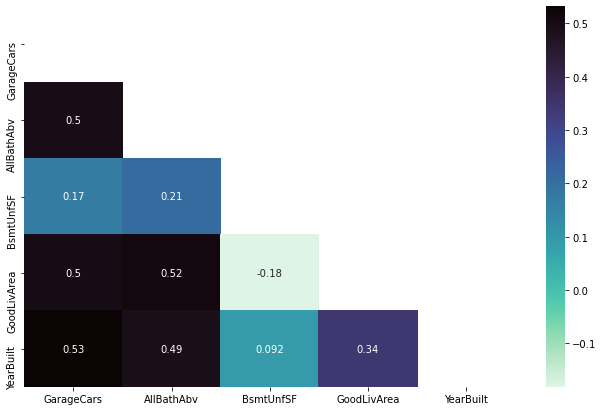

In [14]:
corr = data[['GarageCars','AllBathAbv','BsmtUnfSF','GoodLivArea', 'YearBuilt']].corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

### DistancefromWalmart & YearBuilt high Correlation??

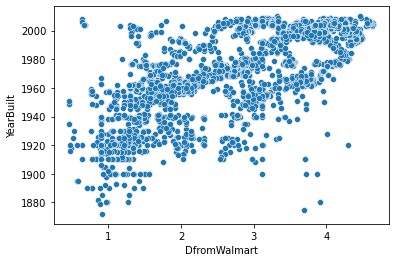

In [135]:
ax1 = sns.scatterplot(x='DfromWalmart',y='YearBuilt',data=data)
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(colors='white', which='both')

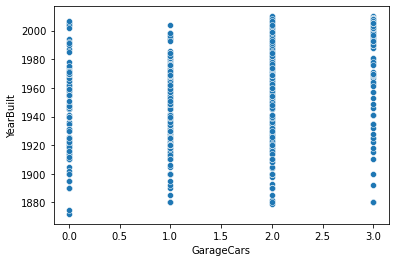

In [15]:
ax1 = sns.scatterplot(x='GarageCars',y='YearBuilt',data=data)

## 📉 Multiple Regression 2 - drop YearBuilt

In [17]:
# Again without YearBuilt
new_data = data.drop(['YearBuilt'],axis=1)
data_dum = pd.get_dummies(new_data, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(data_dum, y, test_size=0.25)
lasso = Lasso()
lasso.set_params(normalize=True, max_iter=10000, random_state=44)

Lasso(max_iter=10000, normalize=True, random_state=44)

In [18]:
#try different alphas
alphas = np.linspace(0,0.002,100)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso.coef_)
    R2_train.append(lasso.score(X_train, np.log10(y_train)))
    R2_test.append(lasso.score(X_test, np.log10(y_test)))
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

<ipython-input-18-6ee417506c91>:9: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train, np.log10(y_train))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.212957225169131, tolerance: 0.0054751577196544545
  model = cd_fast.enet_coordinate_descent(


,BsmtUnfSF,AllBathBsmt,AllBathAbv,GarageCars,PorchArea,GoodLivArea,HasPool,MSSubClass_1FlPUD,MSSubClass_2Fl,MSSubClass_2FlPUD,...,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA
0.00000,0.000064,0.012052,0.013253,0.017810,0.000037,0.000100,-0.002611,-0.020296,0.017208,-0.059768,...,-0.013851,0.000632,-0.022489,-0.010324,-0.006549,-0.118888,-0.066075,-0.101896,-0.149273,-0.095914
0.00002,0.000060,0.008007,0.013267,0.022841,0.000037,0.000104,0.000000,-0.006121,0.014837,-0.049504,...,-0.002394,0.006819,-0.016989,-0.000190,0.000000,-0.020728,0.024390,-0.000000,-0.026056,0.000000


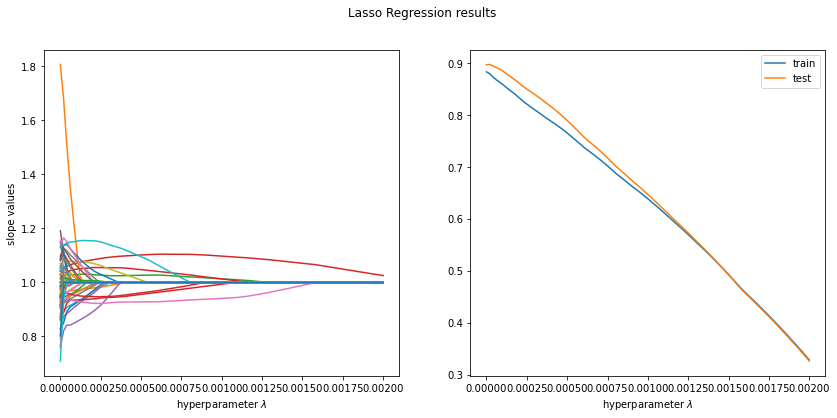

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat]) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
#ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

In [20]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# VIFs over 10
vif[vif.VIF>10]

,var,VIF
2,AllBathAbv,27.857762
3,GarageCars,21.003147
5,GoodLivArea,31.919084
18,PavedDrive_Y,21.008594
26,Neighborhood_CollgCr,11.310916
36,Neighborhood_NAmes,21.001444
41,Neighborhood_OldTown,11.128148
49,CentralAir_Y,27.804823
51,KitchenQual_Gd,14.159021
53,KitchenQual_TA,21.936389


# Try permutation importance

In [21]:
# First set param and retrain
lasso.set_params(alpha=0.00001)
lasso.fit(X_train, np.log10(y_train))

Lasso(alpha=1e-05, max_iter=10000, normalize=True, random_state=44)

In [22]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    lasso, X_train, np.log10(y_train), n_repeats=30, random_state=0)

importances = []
for i in r.importances_mean.argsort()[::-1]:
    importances.append(
        [X_train.columns[i], i, np.round(r.importances_mean[i],4), r.importances_std[i]]
    )

In [23]:
pd.set_option('display.max_rows', None)
importances_df = pd.DataFrame(
    importances, columns = ["feature", "feature_idx", "mean_importance", "std_importance"])
importances_df

,feature,feature_idx,mean_importance,std_importance
0,GoodLivArea,5,0.3881,0.009592
1,KitchenQual_TA,53,0.0563,0.002783
2,BsmtUnfSF,0,0.0472,0.002862
3,ExterQual_TA,56,0.0350,0.002286
4,GarageCars,3,0.0166,0.001400
5,KitchenQual_Gd,51,0.0146,0.001344
6,CentralAir_Y,49,0.0127,0.001306
7,Neighborhood_Somerst,45,0.0118,0.001014
8,ExterQual_Gd,55,0.0116,0.001309
9,KitchenQual_Fa,50,0.0107,0.001279


In [103]:
lm = LinearRegression()
lm.fit(data[['DfromWalmart']],np.log10(y))
print(lm.score(data[['DfromWalmart']],np.log10(y)))
lm.fit(data[['YearBuilt']],np.log10(y))
print(lm.score(data[['YearBuilt']],np.log10(y)))

0.2093795637271657
0.35699696242540935


In [104]:
# Drop Distance from Walmart
data_2.drop('DfromWalmart',axis=1, inplace=True)

### GarageArea & GarageCars high Correlation

In [105]:
lm = LinearRegression()
lm.fit(data[['GarageArea']],np.log10(y))
lm.score(data[['GarageArea']],np.log10(y))

0.41650204802415003

In [106]:
lm = LinearRegression()
lm.fit(data[['GarageCars']],np.log10(y))
lm.score(data[['GarageCars']],np.log10(y))

0.45677789237368716

#### Try PCA to combine Features
'GarageCars', 'GarageArea'<br>

In [107]:
from sklearn.decomposition import PCA
ss = StandardScaler()

pca_data = data_2[['GarageCars','GarageArea']]
pca_data = ss.fit_transform(pca_data)

pca = PCA()
pca.fit(pca_data)
np.round(pca.explained_variance_ratio_,5)

array([0.94316, 0.05684])

In [108]:
# Keep 1 PCA transformed GarageData
new_data = data_2.drop(['GarageCars','GarageArea'],axis=1)
pca.set_params(n_components=1)
new_data = pd.concat([new_data.reset_index(),pd.DataFrame(pca.fit_transform(pca_data))],axis=1)
new_data = new_data.rename(columns={0:'GaragePCA'}).set_index('PID')

In [109]:
new_data.columns

Index(['MSSubClass', 'GarageType', 'BsmtQual', 'Foundation', 'PavedDrive',
       'BsmtUnfSF', 'AllBathBsmt', 'AllBathAbv', 'TotRmsAbvGrd', 'Fireplaces',
       'HeatingQC', 'Neighborhood', 'YearBuilt', 'OverallQual', 'LotFrontage',
       '1stFlrSF', '2ndFlrSF', 'PorchArea', 'BsmtFinSF', 'HasPool',
       'GaragePCA'],
      dtype='object')

In [121]:
R2_lasso.loc[R2_lasso['test'] == max(R2_lasso['test'])]

,train,test
0.0,0.902696,0.882785


In [122]:
lasso.set_params(alpha=0.00001)

Lasso(alpha=1e-05, max_iter=10000, normalize=True, random_state=44)

In [124]:
lasso.fit(X_train, np.log10(y_train))
lasso.score(X_test, np.log10(y_test))

0.8828779325002578